In [14]:
import pandas as pd

def preprocess_data(df_train, df_test):
    # Chuyển cột 'time' về kiểu datetime
    df_train['time'] = pd.to_datetime(df_train['time'])
    df_test['time'] = pd.to_datetime(df_test['time'])
    
    # Lọc bỏ các ngày mà cả 'high' và 'low' đều bị thiếu
    df_train = df_train.dropna(subset=['high', 'low'], how='all').reset_index(drop=True)
    df_test = df_test.dropna(subset=['high', 'low'], how='all').reset_index(drop=True)
    
    # Gắn nhãn để phân biệt dữ liệu train và test sau khi ghép nối
    df_train['dataset'] = 'train'
    df_test['dataset'] = 'test'
    
    # Nối dữ liệu train và test để tạo tính liên tục cho các đặc trưng lag
    df_all = pd.concat([df_train, df_test], ignore_index=True)
    df_all = df_all.sort_values('time').reset_index(drop=True)
    
    # Tạo các đặc trưng lag cho 'high' và 'low'
    df_all['lag1_high'] = df_all['high'].shift(1)
    df_all['lag1_low'] = df_all['low'].shift(1)
    
    # Tạo các đặc trưng trung bình trượt (moving average) với cửa sổ 3 ngày
    df_all['ma3_high'] = df_all['high'].rolling(window=3, min_periods=1).mean()
    df_all['ma3_low'] = df_all['low'].rolling(window=3, min_periods=1).mean()
    
    # Nếu cần thêm các đặc trưng khác, có thể bổ sung ở đây
    
    # Tách lại dữ liệu train và test
    df_train_processed = df_all[df_all['dataset'] == 'train'].drop(columns=['dataset']).reset_index(drop=True)
    df_test_processed = df_all[df_all['dataset'] == 'test'].drop(columns=['dataset']).reset_index(drop=True)

    df_train_processed = df_train_processed.dropna()
    df_test_processed = df_test_processed.dropna()
    
    return df_train_processed, df_test_processed


In [15]:
import pandas as pd

def advanced_feature_engineering(df_train_processed, df_test_processed):
    # Gắn nhãn để phân biệt dữ liệu train và test
    df_train_processed = df_train_processed.copy()
    df_test_processed = df_test_processed.copy()
    df_train_processed['dataset'] = 'train'
    df_test_processed['dataset'] = 'test'
    
    # Nối dữ liệu train và test theo thứ tự thời gian
    df_all = pd.concat([df_train_processed, df_test_processed], ignore_index=True)
    df_all = df_all.sort_values('time').reset_index(drop=True)
    
    # Tạo các đặc trưng cơ bản:
    # Mid price và spread
    df_all['mid'] = (df_all['high'] + df_all['low']) / 2
    df_all['spread'] = df_all['high'] - df_all['low']
    
    # Tính % biến động của mid price so với ngày trước
    df_all['return_1'] = df_all['mid'].pct_change()
    
    # Các chỉ báo trung bình động (Moving Average) với các cửa sổ 5, 10, 20 ngày
    df_all['ma5'] = df_all['mid'].rolling(window=5, min_periods=1).mean()
    df_all['ma10'] = df_all['mid'].rolling(window=10, min_periods=1).mean()
    df_all['ma20'] = df_all['mid'].rolling(window=20, min_periods=1).mean()
    
    # Đo lường độ biến động (volatility) với cửa sổ 5 và 10 ngày (dùng std của mid price)
    df_all['vol5'] = df_all['mid'].rolling(window=5, min_periods=1).std()
    df_all['vol10'] = df_all['mid'].rolling(window=10, min_periods=1).std()
    
    # Các đặc trưng về phân phối: skewness và kurtosis của mid price
    df_all['skew5'] = df_all['mid'].rolling(window=5, min_periods=1).skew()
    df_all['kurt5'] = df_all['mid'].rolling(window=5, min_periods=1).kurt()
    df_all['skew10'] = df_all['mid'].rolling(window=10, min_periods=1).skew()
    df_all['kurt10'] = df_all['mid'].rolling(window=10, min_periods=1).kurt()
    
    # Exponential Moving Average (EMA) để làm mượt dữ liệu
    df_all['ema10'] = df_all['mid'].ewm(span=10, adjust=False).mean()
    
    # Tín hiệu động lượng: hiệu số giữa giá hiện tại và các đường trung bình
    df_all['diff_ma5'] = df_all['mid'] - df_all['ma5']
    df_all['diff_ma10'] = df_all['mid'] - df_all['ma10']
    df_all['diff_ma20'] = df_all['mid'] - df_all['ma20']
    df_all['diff_ema10'] = df_all['mid'] - df_all['ema10']
    
    # Tạo thêm một số lag của mid price
    df_all['lag1_mid'] = df_all['mid'].shift(1)
    df_all['lag2_mid'] = df_all['mid'].shift(2)
    
    # Tỷ lệ giữa spread và mid (có thể dùng để đo lường mức độ biến động tương đối)
    df_all['range_ratio'] = df_all['spread'] / df_all['mid']
    
    # Tính các quantile của mid price (ví dụ, quantile 25% và 75% với cửa sổ 10 ngày)
    df_all['quantile_25'] = df_all['mid'].rolling(window=10, min_periods=1).quantile(0.25)
    df_all['quantile_75'] = df_all['mid'].rolling(window=10, min_periods=1).quantile(0.75)
    
    # Sau khi tạo đặc trưng, loại bỏ các dòng có NaN (do tính toán lag, rolling,...)
    df_all = df_all.dropna().reset_index(drop=True)
    
    # Tách lại dữ liệu train và test
    df_train_feat = df_all[df_all['dataset'] == 'train'].drop(columns=['dataset']).reset_index(drop=True)
    df_test_feat = df_all[df_all['dataset'] == 'test'].drop(columns=['dataset']).reset_index(drop=True)
    
    return df_train_feat, df_test_feat

# Ví dụ sử dụng:
# Giả sử bạn đã xử lý trước với preprocess_data và dropna như:
# df_train_processed = preprocess_data(df_train, df_test)[0].dropna()
# df_test_processed = preprocess_data(df_train, df_test)[1].dropna()
# Sau đó:
# df_train_feat, df_test_feat = advanced_feature_engineering(df_train_processed, df_test_processed)


In [16]:
symbol = 'ACB'
df_train = pd.read_csv(f'../data/2023/vn30/{symbol}.csv')
df_test = pd.read_csv(f'../data/2025/vn30/{symbol}.csv')

In [17]:
df_train_processed, df_test_processed = preprocess_data(df_train, df_test)

In [19]:
df_train_feat, df_test_feat = advanced_feature_engineering(df_train_processed, df_test_processed)

[0]	train-rmse:2.77188	valid-rmse:3.92945
[100]	train-rmse:1.05220	valid-rmse:1.95371
[200]	train-rmse:0.41661	valid-rmse:1.20940
[300]	train-rmse:0.18354	valid-rmse:0.93714
[400]	train-rmse:0.09455	valid-rmse:0.82300
[500]	train-rmse:0.05841	valid-rmse:0.76895
[600]	train-rmse:0.04254	valid-rmse:0.73101
[700]	train-rmse:0.03508	valid-rmse:0.70928
[800]	train-rmse:0.03131	valid-rmse:0.69341
[900]	train-rmse:0.02912	valid-rmse:0.68102
[999]	train-rmse:0.02754	valid-rmse:0.67613
Tỉ lệ dự đoán mid nằm trong [low, high] trên test: 0.00%


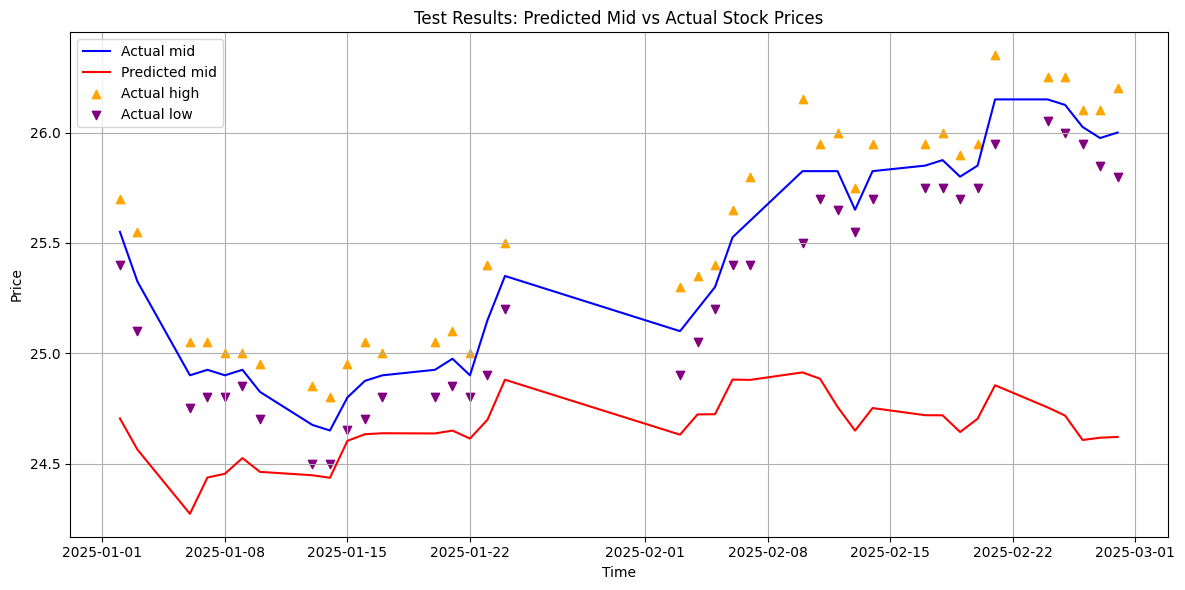

In [25]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# ------------------------------------------------
# 1) Tiền xử lý
# ------------------------------------------------
def preprocess_data(df_train, df_test):
    """
    - Đổi cột 'time' về datetime
    - Lọc bỏ các dòng mà cả 'high' và 'low' đều NaN
    - Tạo các đặc trưng lag đơn giản (lag1_high, lag1_low, ma3_high, ma3_low)
    - Tách lại df_train_processed, df_test_processed
    - Loại bỏ NaN còn sót lại
    """
    # Đảm bảo 'time' dạng datetime
    df_train['time'] = pd.to_datetime(df_train['time'])
    df_test['time'] = pd.to_datetime(df_test['time'])
    
    # Loại bỏ dòng mà cả high, low đều thiếu
    df_train = df_train.dropna(subset=['high', 'low'], how='all').reset_index(drop=True)
    df_test = df_test.dropna(subset=['high', 'low'], how='all').reset_index(drop=True)
    
    # Gắn nhãn train/test rồi nối để tính các đặc trưng liên tục
    df_train['dataset'] = 'train'
    df_test['dataset'] = 'test'
    df_all = pd.concat([df_train, df_test], ignore_index=True).sort_values('time').reset_index(drop=True)
    
    # Tạo lag
    df_all['lag1_high'] = df_all['high'].shift(1)
    df_all['lag1_low'] = df_all['low'].shift(1)
    # Trung bình trượt 3 ngày
    df_all['ma3_high'] = df_all['high'].rolling(window=3, min_periods=1).mean()
    df_all['ma3_low'] = df_all['low'].rolling(window=3, min_periods=1).mean()
    
    # Tách lại
    df_train_processed = df_all[df_all['dataset'] == 'train'].drop(columns=['dataset']).reset_index(drop=True)
    df_test_processed = df_all[df_all['dataset'] == 'test'].drop(columns=['dataset']).reset_index(drop=True)
    
    # Loại bỏ NaN
    df_train_processed = df_train_processed.dropna().reset_index(drop=True)
    df_test_processed = df_test_processed.dropna().reset_index(drop=True)
    
    return df_train_processed, df_test_processed

# ------------------------------------------------
# 2) Tạo đặc trưng nâng cao
# ------------------------------------------------
def advanced_feature_engineering(df_train_processed, df_test_processed):
    """
    - Tính mid = (high + low)/2, spread = high - low
    - Rolling, EMA, skew, kurt, v.v.
    - Tách lại train/test sau khi nối
    """
    df_train_processed = df_train_processed.copy()
    df_test_processed = df_test_processed.copy()
    
    df_train_processed['dataset'] = 'train'
    df_test_processed['dataset'] = 'test'
    
    df_all = pd.concat([df_train_processed, df_test_processed], ignore_index=True)
    df_all = df_all.sort_values('time').reset_index(drop=True)
    
    # mid, spread
    df_all['mid'] = (df_all['high'] + df_all['low']) / 2
    df_all['spread'] = df_all['high'] - df_all['low']
    
    # return_1: % thay đổi so với ngày trước
    df_all['return_1'] = df_all['mid'].pct_change()
    
    # Moving Averages
    df_all['ma5'] = df_all['mid'].rolling(window=5, min_periods=1).mean()
    df_all['ma10'] = df_all['mid'].rolling(window=10, min_periods=1).mean()
    df_all['ma20'] = df_all['mid'].rolling(window=20, min_periods=1).mean()
    
    # Volatility (std)
    df_all['vol5'] = df_all['mid'].rolling(window=5, min_periods=1).std()
    df_all['vol10'] = df_all['mid'].rolling(window=10, min_periods=1).std()
    
    # Skew, Kurt
    df_all['skew5'] = df_all['mid'].rolling(window=5, min_periods=1).skew()
    df_all['kurt5'] = df_all['mid'].rolling(window=5, min_periods=1).kurt()
    df_all['skew10'] = df_all['mid'].rolling(window=10, min_periods=1).skew()
    df_all['kurt10'] = df_all['mid'].rolling(window=10, min_periods=1).kurt()
    
    # EMA
    df_all['ema10'] = df_all['mid'].ewm(span=10, adjust=False).mean()
    
    # Hiệu giữa mid và MA/EMA
    df_all['diff_ma5'] = df_all['mid'] - df_all['ma5']
    df_all['diff_ma10'] = df_all['mid'] - df_all['ma10']
    df_all['diff_ma20'] = df_all['mid'] - df_all['ma20']
    df_all['diff_ema10'] = df_all['mid'] - df_all['ema10']
    
    # Lag mid
    df_all['lag1_mid'] = df_all['mid'].shift(1)
    df_all['lag2_mid'] = df_all['mid'].shift(2)
    
    # range_ratio
    df_all['range_ratio'] = df_all['spread'] / df_all['mid']
    
    # Rolling quantile
    df_all['quantile_25'] = df_all['mid'].rolling(window=10, min_periods=1).quantile(0.25)
    df_all['quantile_75'] = df_all['mid'].rolling(window=10, min_periods=1).quantile(0.75)
    
    # Drop NaN
    df_all = df_all.dropna().reset_index(drop=True)
    
    df_train_feat = df_all[df_all['dataset'] == 'train'].drop(columns=['dataset']).reset_index(drop=True)
    df_test_feat = df_all[df_all['dataset'] == 'test'].drop(columns=['dataset']).reset_index(drop=True)
    
    return df_train_feat, df_test_feat

# ------------------------------------------------
# 3) Huấn luyện mô hình XGBoost (mục tiêu: mid)
# ------------------------------------------------
def train_regression_model(X, y, params=None, num_rounds=1000):
    """
    Huấn luyện mô hình XGBoost dự đoán mid, không dùng quantile loss.
    Sử dụng train/validation split + early stopping.
    """
    # Tách train/valid
    X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval = xgb.DMatrix(X_val, label=y_val)
    
    if params is None:
        # Tham số cơ bản
        params = {
            'objective': 'reg:squarederror',
            'max_depth': 3,
            'eta': 0.01,
            'verbosity': 1,
            'base_score': float(np.mean(y)),  # Khởi tạo gần giá trị trung bình
            'seed': 42
        }
    
    evals = [(dtrain, 'train'), (dval, 'valid')]
    
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=num_rounds,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=100
    )
    return model

def predict_mid(model, X):
    dtest = xgb.DMatrix(X)
    preds = model.predict(dtest)
    return preds

# ------------------------------------------------
# 4) Vẽ đồ thị đánh giá trên tập test
# ------------------------------------------------
def plot_test_results(df_test_feat):
    """
    Vẽ:
      - mid thực tế
      - dự đoán mid
      - high, low thực tế
    """
    plt.figure(figsize=(12,6))
    df_test_feat['time'] = pd.to_datetime(df_test_feat['time'])
    
    plt.plot(df_test_feat['time'], df_test_feat['mid'], label='Actual mid', color='blue')
    plt.plot(df_test_feat['time'], df_test_feat['pred_mid'], label='Predicted mid', color='red')
    
    # Vẽ high, low
    plt.scatter(df_test_feat['time'], df_test_feat['high'], color='orange', marker='^', label='Actual high')
    plt.scatter(df_test_feat['time'], df_test_feat['low'], color='purple', marker='v', label='Actual low')
    
    plt.title('Test Results: Predicted Mid vs Actual Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# 5) Pipeline chính
# ------------------------------------------------
def main(df_train, df_test):
    # 1. Tiền xử lý
    df_train_processed, df_test_processed = preprocess_data(df_train, df_test)
    
    # 2. Tạo đặc trưng nâng cao
    df_train_feat, df_test_feat = advanced_feature_engineering(df_train_processed, df_test_processed)
    
    # 3. Huấn luyện mô hình dự đoán mid
    target_col = 'mid'
    ignore_cols = ['time', 'high', 'low', 'mid']
    feature_cols = [col for col in df_train_feat.columns if col not in ignore_cols]
    
    X_train = df_train_feat[feature_cols]
    y_train = df_train_feat[target_col]
    
    model = train_regression_model(X_train, y_train)
    
    # 4. Dự đoán trên test
    X_test = df_test_feat[feature_cols]
    df_test_feat['pred_mid'] = predict_mid(model, X_test)
    
    # 5. Đánh giá bằng cách tính tỉ lệ predicted mid nằm trong [low, high]
    df_test_feat['in_range'] = ((df_test_feat['pred_mid'] >= df_test_feat['low']) &
                                (df_test_feat['pred_mid'] <= df_test_feat['high'])).astype(int)
    coverage_rate = df_test_feat['in_range'].mean()
    print(f"Tỉ lệ dự đoán mid nằm trong [low, high] trên test: {coverage_rate:.2%}")
    
    # 6. Vẽ đồ thị
    plot_test_results(df_test_feat)
    
    return df_test_feat, model

# ------------------------------------------------
# 6) Ví dụ sử dụng
# ------------------------------------------------
# Giả sử df_train, df_test đã được load với cột 'time', 'high', 'low'
df_test_results, model = main(df_train, df_test)

